<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = "Alireza Farajtabrizi"
studentId = "403206554"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [ ]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # you can change this if you like

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [ ]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [ ]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [ ]:
class CouplingTransform(Transform):
    def __init__(self, mask, hidden_dims, s_net_f=None, t_net_f=None):
        """
        Args:
            mask: a 1-dim tensor, tuple or list. It indexes inputs as follows:
                * If `mask[i] > 0`, `input[i]` will be transformed.
                * If `mask[i] <= 0`, `input[i]` will be passed unchanged.
            hidden_dims: Number of hidden units in the coupling neural networks.
            s_net_f: A function taking (input_dim, output_dim, hidden_dims) returning a Neural Network for Scaling function
            t_net_f: A function taking (input_dim, output_dim, hidden_dims) returning a Neural Network for Translating function
        """
        super(CouplingTransform, self).__init__()

        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dim tensor.")
        if mask.numel() <= 0:
            raise ValueError("Mask can't be empty.")

        self.register_buffer('mask', mask)

        self.num_features = self.mask.numel()
        features_vector = torch.arange(self.num_features)

        #TODO
        if s_net_f is None:
            self.s_net = self._net(self.num_features, self.num_features, hidden_dims)
        else:
            self.s_net = s_net_f(self.num_features, self.num_features, hidden_dims)

        if t_net_f is None:
            self.t_net = self._net(self.num_features, self.num_features, hidden_dims)
        else:
            self.t_net = t_net_f(self.num_features, self.num_features, hidden_dims)

    def _net(self, input_dim, output_dim, hidden_dims):
        net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dim)).to(device)
        return net


    def forward(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )
        # TODO
        x_masked = inputs * (1 - self.mask)

        s = torch.tanh(self.s_net(x_masked))
        t = self.t_net(x_masked)

        z = x_masked + self.mask * (inputs * torch.exp(s) + t)
        log_det_J = (self.mask * s).sum(dim=1)

        return z, log_det_J


    def inverse(self, inputs, context=None):
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")

        if inputs.shape[1] != self.num_features:
            raise ValueError(
                f"Expected features = {self.num_features}, got {inputs.shape[1]}."
            )
        x_masked = inputs * (1 - self.mask)

        s = torch.tanh(self.s_net(x_masked))
        t = self.t_net(x_masked)

        z = x_masked + self.mask * ((inputs - t) * torch.exp(-s))

        return z

In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [ ]:
# Flow Model
class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None):
        super(Flow, self).__init__()
        self.transforms = nn.ModuleList(transforms).to(device)
        self.num_features = self.transforms[0].num_features
        if base_distribution is None:
            self.base_distribution = D.MultivariateNormal(
                loc=torch.zeros(self.num_features, device=device),
                covariance_matrix=torch.eye(self.num_features, device=device)
            )
        else:
            self.base_distribution = base_distribution

    def forward(self, z):
        # TODO
        log_det_J = 0
        for transform in self.transforms:
            z, log_det = transform(z)
            log_det_J += log_det
        return z, log_det_J


    def inverse(self, x):
        # TODO
        for transform in reversed(self.transforms):
            x = transform.inverse(x)
        return x

    def log_prob(self, x):
        # TODO
        # hint: use base_distribution.log_prob(args)
        z = self.inverse(x)
        _, log_det_J = self.forward(z)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z - log_det_J

    def sample(self, num_samples):
        # TODO
        # hint: use base_distribution.sample(args)
        z = self.base_distribution.sample((num_samples,))
        x, _ = self.forward(z)
        return x

    def sample_and_log_prob(self, num_samples):
        # TODO
        z = self.base_distribution.sample((num_samples,))
        log_prob_z = self.base_distribution.log_prob(z)
        x, log_det_J = self.forward(z)
        log_prob = log_prob_z - log_det_J
        return x, log_prob

Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [ ]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(i + j) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

In [ ]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = 64
batch_size = 256
learning_rate = 1e-3
num_epochs = 500

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

In [ ]:
# Define masks for alternating coupling layers
masks = create_alternating_masks(num_features, num_layers)

# Initialize transforms
transforms = []
for i in range(num_layers):
    transforms.append(CouplingTransform(masks[i], hidden_dims))
    transforms.append(PermutationTransform(num_features))

# Initialize base distribution
base_dist = D.MultivariateNormal(
                loc=torch.zeros(num_features, device=device),
                covariance_matrix=torch.eye(num_features, device=device))

# Initialize Flow model
flow = Flow(transforms=transforms, base_distribution=base_dist).to(device)


Epoch 1/500, Loss: 2.7000


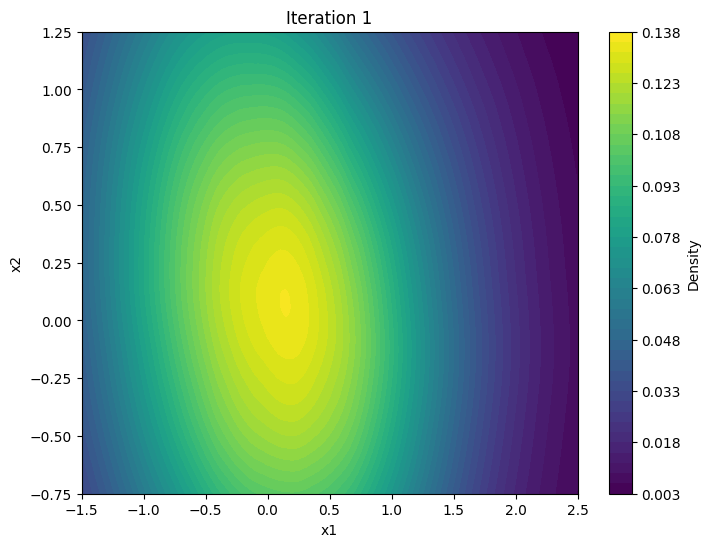

Epoch 200/500, Loss: 1.2607


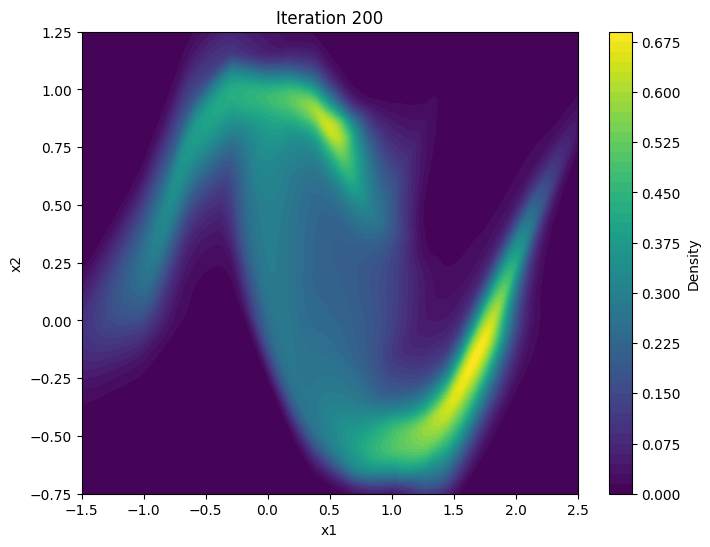

Epoch 400/500, Loss: 1.2489


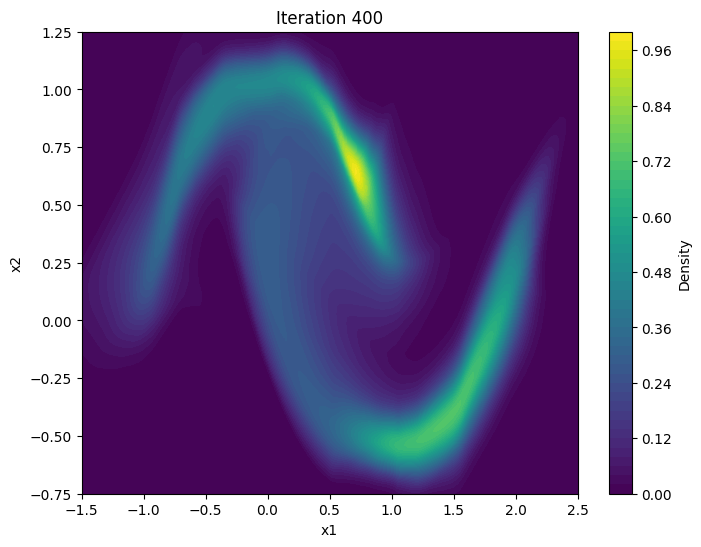

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Generate batch data
    x, _ = make_moons(n_samples=batch_size, noise=0.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    #TODO
    log_prob = flow.log_prob(x)
    loss = - log_prob.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

        # Visualization of the learned density
        with torch.no_grad():
            xline = torch.linspace(-1.5, 2.5, 200, device=device)
            yline = torch.linspace(-0.75, 1.25, 200, device=device)
            xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
            xyinput = torch.cat([
                xgrid.reshape(-1, 1),
                ygrid.reshape(-1, 1)
            ], dim=1).to(device)

            log_prob_grid = flow.log_prob(xyinput)
            zgrid = torch.exp(log_prob_grid).reshape(200, 200).cpu()

        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Iteration {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()

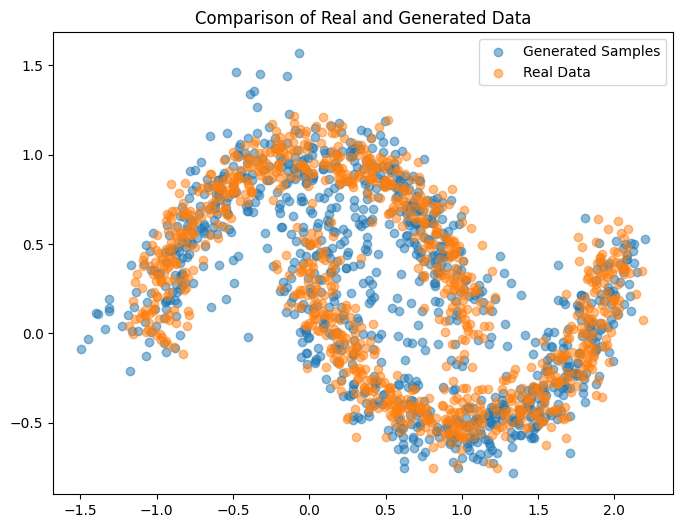

In [ ]:
# Sampling from the flow
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()
    x_real, _ = make_moons(1000, noise=0.1)

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples')
    plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data')
    plt.legend()
    plt.title('Comparison of Real and Generated Data')
    plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.

In [ ]:
!pip install normflows

In [2]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [3]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [8]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [12]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [13]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [14]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_iter = iter(train_loader)

for i in tqdm(range(max_iter)):
## TODO training loop ( hint: use model.forward_kld(x), gives the log prob  )
    try:
        x, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, _ = next(train_iter)
    x = x.to(device)

    # Forward pass and compute the loss
    loss = model.forward_kld(x)

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

    # Save checkpoint periodically
    if (i + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
        torch.save({
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': loss_hist,
        }, checkpoint_path)
        print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')

 20%|██        | 2001/10000 [04:24<19:19,  6.90it/s]

Checkpoint saved at iteration 2000 to checkpoints/model_iter_2000.pth


 40%|████      | 4001/10000 [08:47<14:34,  6.86it/s]

Checkpoint saved at iteration 4000 to checkpoints/model_iter_4000.pth


 60%|██████    | 6001/10000 [13:04<10:03,  6.63it/s]

Checkpoint saved at iteration 6000 to checkpoints/model_iter_6000.pth


 80%|████████  | 8001/10000 [17:21<04:51,  6.86it/s]

Checkpoint saved at iteration 8000 to checkpoints/model_iter_8000.pth


100%|██████████| 10000/10000 [21:41<00:00,  7.69it/s]

Checkpoint saved at iteration 10000 to checkpoints/model_iter_10000.pth


In [15]:
# Save the final model after training
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
}, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to checkpoints/model_final.pth


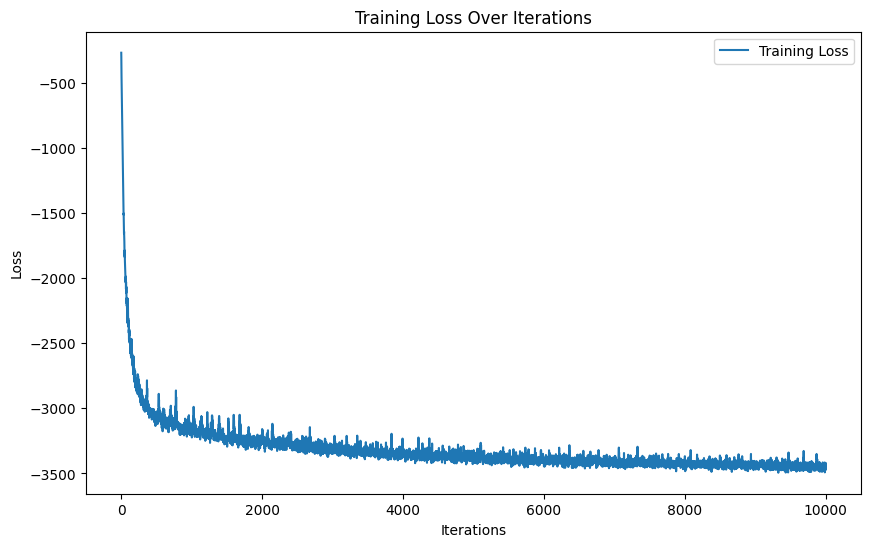

In [16]:
# TODO Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()


## Evaluation

To evaluate our model, we can just draw samples from our model.

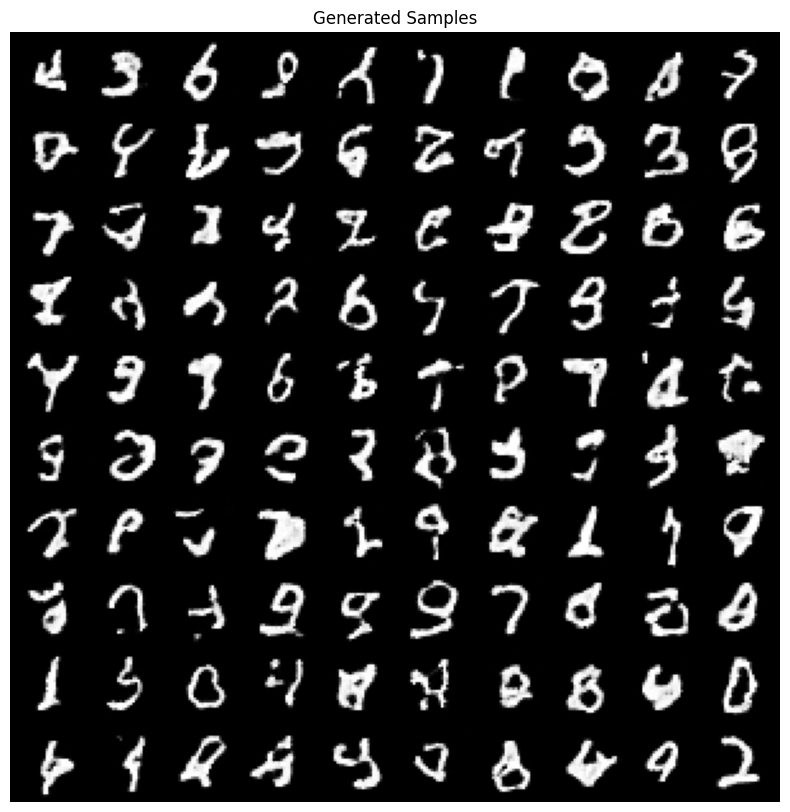

In [18]:
# Model samples
num_samples_per_grid = 10  # Number of samples per grid row
total_samples = num_samples_per_grid * num_samples_per_grid  # Total samples to generate


with torch.no_grad():
    # Sample from the base distribution
    x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed
    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [20]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    masked_image = image.clone()
    # TODO:
    top = torch.randint(0, H - mask_size + 1, (1,)).item()
    left = torch.randint(0, W - mask_size + 1, (1,)).item()

    mask = torch.zeros((H, W), dtype=torch.float32)
    mask[top:top+mask_size, left:left+mask_size] = 1.0
    masked_image[:, top:top+mask_size, left:left+mask_size] = 0.0

    # suggestion: Sample a random top-left corner for the square

    # Apply the mask. Assume 0 is the mask value

    return masked_image, mask


In [21]:
# @title Optional random noise mask
def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask


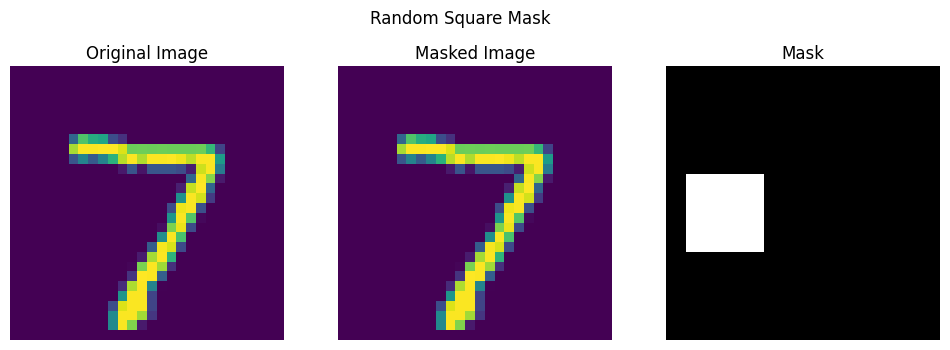

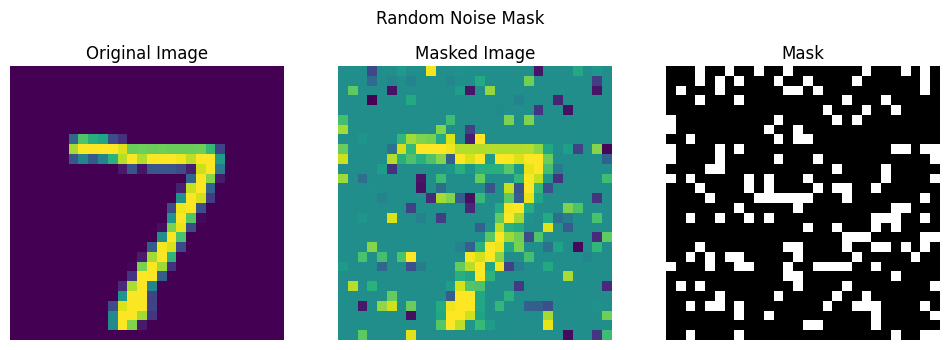

In [66]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.permute(1, 2, 0).cpu().numpy()
    masked = masked_image.permute(1, 2, 0).cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked)
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Example usage
# Assuming `sample_image` is a tensor [C, H, W] from your dataset
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")

In [213]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # TODO:
    # Initialize the missing pixels to zeros (can also use random noise)
    # Create a tensor that will hold the missing pixels
    missing_pixels = torch.empty_like(masked_image).uniform_().to(device).unsqueeze(0)

    # Make missing_pixels a learnable parameter
    missing_pixels = torch.nn.Parameter(missing_pixels)

    # Define optimizer
    optimizer = optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels
        reconstructed_image = inpainted_image * (1 - mask) + missing_pixels * mask
        log_likelihood = model.forward_kld(reconstructed_image)
        loss = log_likelihood.mean()
        # Backpropagation ( model.forward_kld() gives the log prob )
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          missing_pixels.data = missing_pixels.data.clamp(0.0, 1.0)
        # clamp the missing pixels to valid range (e.g., [0, 1])


        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    return reconstructed_image.squeeze(1)


In [218]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=1000, lr=0.1))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting:   1%|          | 10/1000 [00:00<01:27, 11.33it/s]

Step [10/1000], Loss: -3129.1345


Inpainting:   2%|▏         | 21/1000 [00:02<01:56,  8.39it/s]

Step [20/1000], Loss: -3197.3269


Inpainting:   3%|▎         | 31/1000 [00:03<02:11,  7.36it/s]

Step [30/1000], Loss: -3212.8940


Inpainting:   4%|▍         | 42/1000 [00:04<01:28, 10.80it/s]

Step [40/1000], Loss: -3245.5693


Inpainting:   5%|▌         | 52/1000 [00:05<01:23, 11.30it/s]

Step [50/1000], Loss: -3253.8477


Inpainting:   6%|▌         | 62/1000 [00:06<01:22, 11.34it/s]

Step [60/1000], Loss: -3257.4766


Inpainting:   7%|▋         | 72/1000 [00:07<01:22, 11.21it/s]

Step [70/1000], Loss: -3256.9558


Inpainting:   8%|▊         | 82/1000 [00:08<01:19, 11.53it/s]

Step [80/1000], Loss: -3280.6880


Inpainting:   9%|▉         | 92/1000 [00:09<01:20, 11.26it/s]

Step [90/1000], Loss: -3276.9521


Inpainting:  10%|█         | 102/1000 [00:09<01:18, 11.47it/s]

Step [100/1000], Loss: -3295.1562


Inpainting:  11%|█         | 112/1000 [00:10<01:18, 11.31it/s]

Step [110/1000], Loss: -3291.0791


Inpainting:  12%|█▏        | 122/1000 [00:11<01:16, 11.40it/s]

Step [120/1000], Loss: -3301.3057


Inpainting:  13%|█▎        | 132/1000 [00:12<01:16, 11.34it/s]

Step [130/1000], Loss: -3311.7515


Inpainting:  14%|█▍        | 140/1000 [00:13<01:17, 11.10it/s]

Step [140/1000], Loss: -3316.8127


Inpainting:  15%|█▌        | 151/1000 [00:14<01:42,  8.27it/s]

Step [150/1000], Loss: -3323.5576


Inpainting:  16%|█▌        | 161/1000 [00:15<01:50,  7.57it/s]

Step [160/1000], Loss: -3299.5732


Inpainting:  17%|█▋        | 172/1000 [00:16<01:16, 10.77it/s]

Step [170/1000], Loss: -3295.1912


Inpainting:  18%|█▊        | 182/1000 [00:17<01:12, 11.25it/s]

Step [180/1000], Loss: -3311.5710


Inpainting:  19%|█▉        | 192/1000 [00:18<01:11, 11.30it/s]

Step [190/1000], Loss: -3320.8035


Inpainting:  20%|██        | 202/1000 [00:19<01:11, 11.22it/s]

Step [200/1000], Loss: -3324.3447


Inpainting:  21%|██        | 212/1000 [00:20<01:09, 11.37it/s]

Step [210/1000], Loss: -3329.8013


Inpainting:  22%|██▏       | 222/1000 [00:21<01:08, 11.37it/s]

Step [220/1000], Loss: -3314.9644


Inpainting:  23%|██▎       | 232/1000 [00:22<01:08, 11.20it/s]

Step [230/1000], Loss: -3312.7734


Inpainting:  24%|██▍       | 242/1000 [00:23<01:05, 11.53it/s]

Step [240/1000], Loss: -3306.5703


Inpainting:  25%|██▌       | 252/1000 [00:24<01:07, 11.15it/s]

Step [250/1000], Loss: -3318.5273


Inpainting:  26%|██▌       | 262/1000 [00:24<01:05, 11.19it/s]

Step [260/1000], Loss: -3326.4312


Inpainting:  27%|██▋       | 272/1000 [00:25<01:05, 11.06it/s]

Step [270/1000], Loss: -3308.4341


Inpainting:  28%|██▊       | 281/1000 [00:26<01:23,  8.57it/s]

Step [280/1000], Loss: -3307.9841


Inpainting:  29%|██▉       | 291/1000 [00:28<01:33,  7.61it/s]

Step [290/1000], Loss: -3318.8643


Inpainting:  30%|███       | 302/1000 [00:29<01:06, 10.47it/s]

Step [300/1000], Loss: -3330.3264


Inpainting:  31%|███       | 312/1000 [00:30<01:01, 11.19it/s]

Step [310/1000], Loss: -3298.8652


Inpainting:  32%|███▏      | 322/1000 [00:31<00:59, 11.42it/s]

Step [320/1000], Loss: -3313.6392


Inpainting:  33%|███▎      | 332/1000 [00:31<00:59, 11.23it/s]

Step [330/1000], Loss: -3321.2012


Inpainting:  34%|███▍      | 340/1000 [00:32<00:57, 11.38it/s]

Step [340/1000], Loss: -3313.4846


Inpainting:  35%|███▌      | 351/1000 [00:34<01:25,  7.60it/s]

Step [350/1000], Loss: -3322.5085


Inpainting:  36%|███▌      | 361/1000 [00:35<01:14,  8.61it/s]

Step [360/1000], Loss: -3333.4009


Inpainting:  37%|███▋      | 372/1000 [00:36<01:01, 10.24it/s]

Step [370/1000], Loss: -3322.4304


Inpainting:  38%|███▊      | 380/1000 [00:37<01:00, 10.24it/s]

Step [380/1000], Loss: -3339.1992


Inpainting:  39%|███▉      | 390/1000 [00:39<02:05,  4.88it/s]

Step [390/1000], Loss: -3321.2939


Inpainting:  40%|████      | 401/1000 [00:41<01:30,  6.64it/s]

Step [400/1000], Loss: -3327.6504


Inpainting:  41%|████      | 412/1000 [00:42<01:02,  9.46it/s]

Step [410/1000], Loss: -3316.7083


Inpainting:  42%|████▏     | 422/1000 [00:43<00:59,  9.70it/s]

Step [420/1000], Loss: -3322.8430


Inpainting:  43%|████▎     | 432/1000 [00:44<00:51, 11.11it/s]

Step [430/1000], Loss: -3323.2385


Inpainting:  44%|████▍     | 442/1000 [00:45<00:51, 10.93it/s]

Step [440/1000], Loss: -3332.2737


Inpainting:  45%|████▌     | 452/1000 [00:46<00:48, 11.26it/s]

Step [450/1000], Loss: -3331.7417


Inpainting:  46%|████▌     | 462/1000 [00:47<00:49, 10.84it/s]

Step [460/1000], Loss: -3325.6633


Inpainting:  47%|████▋     | 472/1000 [00:48<00:47, 11.08it/s]

Step [470/1000], Loss: -3323.0283


Inpainting:  48%|████▊     | 481/1000 [00:49<01:09,  7.44it/s]

Step [480/1000], Loss: -3327.0566


Inpainting:  49%|████▉     | 491/1000 [00:51<01:20,  6.34it/s]

Step [490/1000], Loss: -3329.7964


Inpainting:  50%|█████     | 501/1000 [00:52<01:00,  8.22it/s]

Step [500/1000], Loss: -3322.9067


Inpainting:  51%|█████     | 511/1000 [00:53<01:03,  7.70it/s]

Step [510/1000], Loss: -3340.1086


Inpainting:  52%|█████▏    | 522/1000 [00:54<00:47, 10.14it/s]

Step [520/1000], Loss: -3338.6895


Inpainting:  53%|█████▎    | 532/1000 [00:55<00:42, 11.08it/s]

Step [530/1000], Loss: -3314.5605


Inpainting:  54%|█████▍    | 542/1000 [00:56<00:40, 11.38it/s]

Step [540/1000], Loss: -3336.8171


Inpainting:  55%|█████▌    | 552/1000 [00:57<00:39, 11.40it/s]

Step [550/1000], Loss: -3338.7781


Inpainting:  56%|█████▌    | 562/1000 [00:58<00:38, 11.24it/s]

Step [560/1000], Loss: -3321.3523


Inpainting:  57%|█████▋    | 571/1000 [00:59<00:45,  9.39it/s]

Step [570/1000], Loss: -3345.3821


Inpainting:  58%|█████▊    | 581/1000 [01:00<00:37, 11.09it/s]

Step [580/1000], Loss: -3322.4375


Inpainting:  59%|█████▉    | 591/1000 [01:01<00:36, 11.21it/s]

Step [590/1000], Loss: -3331.8992


Inpainting:  60%|██████    | 602/1000 [01:02<00:43,  9.15it/s]

Step [600/1000], Loss: -3332.2856


Inpainting:  61%|██████    | 611/1000 [01:03<00:48,  8.06it/s]

Step [610/1000], Loss: -3317.5681


Inpainting:  62%|██████▏   | 621/1000 [01:05<00:58,  6.52it/s]

Step [620/1000], Loss: -3297.2988


Inpainting:  63%|██████▎   | 631/1000 [01:07<01:16,  4.84it/s]

Step [630/1000], Loss: -3287.1323


Inpainting:  64%|██████▍   | 641/1000 [01:08<00:42,  8.35it/s]

Step [640/1000], Loss: -3297.0046


Inpainting:  65%|██████▌   | 651/1000 [01:09<00:32, 10.65it/s]

Step [650/1000], Loss: -3307.8711


Inpainting:  66%|██████▌   | 661/1000 [01:10<00:30, 11.01it/s]

Step [660/1000], Loss: -3314.2251


Inpainting:  67%|██████▋   | 671/1000 [01:11<00:28, 11.55it/s]

Step [670/1000], Loss: -3315.8193


Inpainting:  68%|██████▊   | 681/1000 [01:11<00:28, 11.37it/s]

Step [680/1000], Loss: -3317.5049


Inpainting:  69%|██████▉   | 691/1000 [01:13<00:32,  9.43it/s]

Step [690/1000], Loss: -3324.6106


Inpainting:  70%|███████   | 700/1000 [01:14<00:52,  5.68it/s]

Step [700/1000], Loss: -3321.6714


Inpainting:  71%|███████   | 711/1000 [01:16<00:28, 10.03it/s]

Step [710/1000], Loss: -3319.1665


Inpainting:  72%|███████▏  | 721/1000 [01:16<00:25, 10.98it/s]

Step [720/1000], Loss: -3333.2249


Inpainting:  73%|███████▎  | 731/1000 [01:18<00:30,  8.93it/s]

Step [730/1000], Loss: -3315.6777


Inpainting:  74%|███████▍  | 741/1000 [01:19<00:34,  7.51it/s]

Step [740/1000], Loss: -3306.5205


Inpainting:  75%|███████▌  | 751/1000 [01:20<00:23, 10.39it/s]

Step [750/1000], Loss: -3320.1440


Inpainting:  76%|███████▌  | 761/1000 [01:21<00:21, 11.20it/s]

Step [760/1000], Loss: -3328.6074


Inpainting:  77%|███████▋  | 771/1000 [01:22<00:20, 11.37it/s]

Step [770/1000], Loss: -3339.4358


Inpainting:  78%|███████▊  | 781/1000 [01:23<00:19, 11.31it/s]

Step [780/1000], Loss: -3332.3904


Inpainting:  79%|███████▉  | 791/1000 [01:23<00:18, 11.23it/s]

Step [790/1000], Loss: -3331.4485


Inpainting:  80%|████████  | 801/1000 [01:24<00:17, 11.15it/s]

Step [800/1000], Loss: -3322.2637


Inpainting:  81%|████████  | 811/1000 [01:25<00:17, 11.02it/s]

Step [810/1000], Loss: -3323.0815


Inpainting:  82%|████████▏ | 821/1000 [01:26<00:17,  9.96it/s]

Step [820/1000], Loss: -3347.5776


Inpainting:  83%|████████▎ | 831/1000 [01:27<00:19,  8.75it/s]

Step [830/1000], Loss: -3335.4253


Inpainting:  84%|████████▍ | 841/1000 [01:29<00:17,  9.35it/s]

Step [840/1000], Loss: -3336.8916


Inpainting:  85%|████████▌ | 851/1000 [01:30<00:19,  7.62it/s]

Step [850/1000], Loss: -3336.4351


Inpainting:  86%|████████▌ | 861/1000 [01:31<00:18,  7.41it/s]

Step [860/1000], Loss: -3338.2271


Inpainting:  87%|████████▋ | 872/1000 [01:33<00:12, 10.42it/s]

Step [870/1000], Loss: -3332.7087


Inpainting:  88%|████████▊ | 882/1000 [01:34<00:10, 10.98it/s]

Step [880/1000], Loss: -3301.5278


Inpainting:  89%|████████▉ | 892/1000 [01:34<00:09, 11.18it/s]

Step [890/1000], Loss: -3317.6533


Inpainting:  90%|█████████ | 902/1000 [01:35<00:08, 11.16it/s]

Step [900/1000], Loss: -3318.1169


Inpainting:  91%|█████████ | 912/1000 [01:37<00:11,  7.91it/s]

Step [910/1000], Loss: -3342.8059


Inpainting:  92%|█████████▏| 921/1000 [01:38<00:07, 10.35it/s]

Step [920/1000], Loss: -3307.3296


Inpainting:  93%|█████████▎| 931/1000 [01:38<00:06, 10.98it/s]

Step [930/1000], Loss: -3328.3496


Inpainting:  94%|█████████▍| 941/1000 [01:39<00:05, 11.30it/s]

Step [940/1000], Loss: -3323.5286


Inpainting:  95%|█████████▌| 951/1000 [01:40<00:04, 11.53it/s]

Step [950/1000], Loss: -3323.1655


Inpainting:  96%|█████████▌| 961/1000 [01:41<00:03, 11.53it/s]

Step [960/1000], Loss: -3320.1982


Inpainting:  97%|█████████▋| 971/1000 [01:42<00:02, 11.31it/s]

Step [970/1000], Loss: -3326.1655


Inpainting:  98%|█████████▊| 981/1000 [01:43<00:02,  8.60it/s]

Step [980/1000], Loss: -3333.6123


Inpainting:  99%|█████████▉| 991/1000 [01:45<00:01,  7.51it/s]

Step [990/1000], Loss: -3333.7832


Inpainting: 100%|██████████| 1000/1000 [01:45<00:00,  9.44it/s]


Step [1000/1000], Loss: -3317.7058


Inpainting:   1%|          | 12/1000 [00:01<01:27, 11.23it/s]

Step [10/1000], Loss: -3059.1323


Inpainting:   2%|▏         | 22/1000 [00:01<01:28, 11.04it/s]

Step [20/1000], Loss: -3133.3701


Inpainting:   3%|▎         | 32/1000 [00:02<01:24, 11.39it/s]

Step [30/1000], Loss: -3180.9358


Inpainting:   4%|▍         | 42/1000 [00:03<01:24, 11.35it/s]

Step [40/1000], Loss: -3183.8994


Inpainting:   5%|▌         | 52/1000 [00:04<01:25, 11.15it/s]

Step [50/1000], Loss: -3211.9172


Inpainting:   6%|▌         | 62/1000 [00:05<01:24, 11.10it/s]

Step [60/1000], Loss: -3236.8267


Inpainting:   7%|▋         | 72/1000 [00:06<01:21, 11.36it/s]

Step [70/1000], Loss: -3236.1348


Inpainting:   8%|▊         | 82/1000 [00:07<01:20, 11.38it/s]

Step [80/1000], Loss: -3251.5146


Inpainting:   9%|▉         | 92/1000 [00:08<01:20, 11.29it/s]

Step [90/1000], Loss: -3245.1707


Inpainting:  10%|█         | 102/1000 [00:09<01:20, 11.19it/s]

Step [100/1000], Loss: -3233.5972


Inpainting:  11%|█         | 111/1000 [00:10<01:43,  8.59it/s]

Step [110/1000], Loss: -3250.8523


Inpainting:  12%|█▏        | 121/1000 [00:11<02:07,  6.92it/s]

Step [120/1000], Loss: -3267.3057


Inpainting:  13%|█▎        | 132/1000 [00:12<01:23, 10.40it/s]

Step [130/1000], Loss: -3271.0952


Inpainting:  14%|█▍        | 142/1000 [00:13<01:18, 10.96it/s]

Step [140/1000], Loss: -3272.9448


Inpainting:  15%|█▌        | 152/1000 [00:14<01:16, 11.02it/s]

Step [150/1000], Loss: -3283.8523


Inpainting:  16%|█▌        | 162/1000 [00:15<01:14, 11.30it/s]

Step [160/1000], Loss: -3276.0483


Inpainting:  17%|█▋        | 172/1000 [00:16<01:12, 11.34it/s]

Step [170/1000], Loss: -3272.8252


Inpainting:  18%|█▊        | 182/1000 [00:17<01:11, 11.40it/s]

Step [180/1000], Loss: -3257.5327


Inpainting:  19%|█▉        | 192/1000 [00:17<01:11, 11.26it/s]

Step [190/1000], Loss: -3257.3025


Inpainting:  20%|██        | 202/1000 [00:18<01:07, 11.76it/s]

Step [200/1000], Loss: -3267.0901


Inpainting:  21%|██        | 212/1000 [00:19<01:08, 11.48it/s]

Step [210/1000], Loss: -3237.8962


Inpainting:  22%|██▏       | 222/1000 [00:20<01:07, 11.51it/s]

Step [220/1000], Loss: -3258.3301


Inpainting:  23%|██▎       | 232/1000 [00:21<01:08, 11.29it/s]

Step [230/1000], Loss: -3270.8960


Inpainting:  24%|██▍       | 241/1000 [00:22<01:27,  8.72it/s]

Step [240/1000], Loss: -3265.0830


Inpainting:  25%|██▌       | 251/1000 [00:23<01:38,  7.58it/s]

Step [250/1000], Loss: -3249.7031


Inpainting:  26%|██▌       | 261/1000 [00:24<01:16,  9.65it/s]

Step [260/1000], Loss: -3253.5967


Inpainting:  27%|██▋       | 272/1000 [00:25<01:04, 11.28it/s]

Step [270/1000], Loss: -3271.4717


Inpainting:  28%|██▊       | 282/1000 [00:26<01:04, 11.20it/s]

Step [280/1000], Loss: -3258.3899


Inpainting:  29%|██▉       | 292/1000 [00:27<01:03, 11.17it/s]

Step [290/1000], Loss: -3260.9878


Inpainting:  30%|███       | 302/1000 [00:28<01:03, 10.91it/s]

Step [300/1000], Loss: -3268.0342


Inpainting:  31%|███       | 312/1000 [00:29<01:02, 11.00it/s]

Step [310/1000], Loss: -3256.7124


Inpainting:  32%|███▏      | 320/1000 [00:30<01:03, 10.63it/s]

Step [320/1000], Loss: -3264.1592


Inpainting:  33%|███▎      | 331/1000 [00:31<01:21,  8.21it/s]

Step [330/1000], Loss: -3269.0557


Inpainting:  34%|███▍      | 341/1000 [00:32<01:28,  7.46it/s]

Step [340/1000], Loss: -3266.3843


Inpainting:  35%|███▌      | 352/1000 [00:33<01:01, 10.56it/s]

Step [350/1000], Loss: -3242.3159


Inpainting:  36%|███▌      | 361/1000 [00:34<01:07,  9.52it/s]

Step [360/1000], Loss: -3254.6836


Inpainting:  37%|███▋      | 371/1000 [00:36<01:19,  7.95it/s]

Step [370/1000], Loss: -3271.9785


Inpainting:  38%|███▊      | 381/1000 [00:37<01:13,  8.46it/s]

Step [380/1000], Loss: -3268.2639


Inpainting:  39%|███▉      | 391/1000 [00:38<00:56, 10.87it/s]

Step [390/1000], Loss: -3271.0005


Inpainting:  40%|████      | 401/1000 [00:39<01:12,  8.24it/s]

Step [400/1000], Loss: -3268.3953


Inpainting:  41%|████      | 411/1000 [00:40<01:23,  7.06it/s]

Step [410/1000], Loss: -3263.3008


Inpainting:  42%|████▏     | 422/1000 [00:41<00:53, 10.80it/s]

Step [420/1000], Loss: -3263.2949


Inpainting:  43%|████▎     | 432/1000 [00:42<00:51, 11.05it/s]

Step [430/1000], Loss: -3263.2590


Inpainting:  44%|████▍     | 442/1000 [00:43<00:49, 11.26it/s]

Step [440/1000], Loss: -3261.6885


Inpainting:  45%|████▌     | 452/1000 [00:44<00:48, 11.31it/s]

Step [450/1000], Loss: -3262.6692


Inpainting:  46%|████▌     | 462/1000 [00:45<00:47, 11.22it/s]

Step [460/1000], Loss: -3264.3694


Inpainting:  47%|████▋     | 472/1000 [00:46<00:46, 11.26it/s]

Step [470/1000], Loss: -3270.1772


Inpainting:  48%|████▊     | 482/1000 [00:47<00:46, 11.02it/s]

Step [480/1000], Loss: -3281.1135


Inpainting:  49%|████▉     | 491/1000 [00:48<00:59,  8.53it/s]

Step [490/1000], Loss: -3268.8564


Inpainting:  50%|█████     | 501/1000 [00:49<01:08,  7.28it/s]

Step [500/1000], Loss: -3258.2998


Inpainting:  51%|█████     | 512/1000 [00:50<00:45, 10.84it/s]

Step [510/1000], Loss: -3275.7019


Inpainting:  52%|█████▏    | 522/1000 [00:51<00:42, 11.16it/s]

Step [520/1000], Loss: -3273.3071


Inpainting:  53%|█████▎    | 532/1000 [00:52<00:42, 10.98it/s]

Step [530/1000], Loss: -3280.4041


Inpainting:  54%|█████▍    | 542/1000 [00:53<00:41, 11.02it/s]

Step [540/1000], Loss: -3268.2417


Inpainting:  55%|█████▌    | 552/1000 [00:54<00:39, 11.33it/s]

Step [550/1000], Loss: -3263.7598


Inpainting:  56%|█████▌    | 562/1000 [00:55<00:38, 11.38it/s]

Step [560/1000], Loss: -3235.1189


Inpainting:  57%|█████▋    | 572/1000 [00:56<00:37, 11.42it/s]

Step [570/1000], Loss: -3253.7910


Inpainting:  58%|█████▊    | 582/1000 [00:56<00:36, 11.53it/s]

Step [580/1000], Loss: -3259.4956


Inpainting:  59%|█████▉    | 592/1000 [00:57<00:36, 11.31it/s]

Step [590/1000], Loss: -3252.3838


Inpainting:  60%|██████    | 602/1000 [00:58<00:35, 11.09it/s]

Step [600/1000], Loss: -3254.7139


Inpainting:  61%|██████    | 612/1000 [00:59<00:34, 11.29it/s]

Step [610/1000], Loss: -3273.5547


Inpainting:  62%|██████▏   | 621/1000 [01:00<00:43,  8.65it/s]

Step [620/1000], Loss: -3257.1394


Inpainting:  63%|██████▎   | 631/1000 [01:01<00:47,  7.77it/s]

Step [630/1000], Loss: -3250.9712


Inpainting:  64%|██████▍   | 641/1000 [01:02<00:34, 10.52it/s]

Step [640/1000], Loss: -3264.9016


Inpainting:  65%|██████▌   | 651/1000 [01:03<00:31, 11.04it/s]

Step [650/1000], Loss: -3251.1091


Inpainting:  66%|██████▌   | 661/1000 [01:04<00:30, 11.24it/s]

Step [660/1000], Loss: -3272.4727


Inpainting:  67%|██████▋   | 671/1000 [01:05<00:28, 11.37it/s]

Step [670/1000], Loss: -3273.5437


Inpainting:  68%|██████▊   | 679/1000 [01:06<00:28, 11.14it/s]

Step [680/1000], Loss: -3272.4072


Inpainting:  69%|██████▉   | 691/1000 [01:08<00:42,  7.32it/s]

Step [690/1000], Loss: -3271.6365


Inpainting:  70%|███████   | 702/1000 [01:09<00:33,  8.95it/s]

Step [700/1000], Loss: -3263.4897


Inpainting:  71%|███████   | 712/1000 [01:10<00:27, 10.60it/s]

Step [710/1000], Loss: -3251.4993


Inpainting:  72%|███████▏  | 722/1000 [01:11<00:24, 11.27it/s]

Step [720/1000], Loss: -3270.7744


Inpainting:  73%|███████▎  | 732/1000 [01:12<00:23, 11.49it/s]

Step [730/1000], Loss: -3253.1819


Inpainting:  74%|███████▍  | 741/1000 [01:13<00:29,  8.85it/s]

Step [740/1000], Loss: -3252.9248


Inpainting:  75%|███████▌  | 751/1000 [01:14<00:33,  7.38it/s]

Step [750/1000], Loss: -3259.1860


Inpainting:  76%|███████▌  | 761/1000 [01:15<00:23, 10.25it/s]

Step [760/1000], Loss: -3266.1147


Inpainting:  77%|███████▋  | 771/1000 [01:16<00:20, 11.13it/s]

Step [770/1000], Loss: -3269.9302


Inpainting:  78%|███████▊  | 781/1000 [01:17<00:19, 11.26it/s]

Step [780/1000], Loss: -3242.4316


Inpainting:  79%|███████▉  | 791/1000 [01:18<00:18, 11.35it/s]

Step [790/1000], Loss: -3256.0574


Inpainting:  80%|████████  | 801/1000 [01:19<00:17, 11.40it/s]

Step [800/1000], Loss: -3230.2097


Inpainting:  81%|████████  | 811/1000 [01:20<00:16, 11.34it/s]

Step [810/1000], Loss: -3254.3701


Inpainting:  82%|████████▏ | 821/1000 [01:20<00:15, 11.34it/s]

Step [820/1000], Loss: -3271.7686


Inpainting:  83%|████████▎ | 831/1000 [01:21<00:14, 11.30it/s]

Step [830/1000], Loss: -3261.7246


Inpainting:  84%|████████▍ | 841/1000 [01:22<00:13, 11.49it/s]

Step [840/1000], Loss: -3271.5422


Inpainting:  85%|████████▌ | 851/1000 [01:23<00:13, 11.43it/s]

Step [850/1000], Loss: -3275.3740


Inpainting:  86%|████████▌ | 861/1000 [01:24<00:12, 11.29it/s]

Step [860/1000], Loss: -3278.6650


Inpainting:  87%|████████▋ | 871/1000 [01:25<00:13,  9.47it/s]

Step [870/1000], Loss: -3275.8149


Inpainting:  88%|████████▊ | 881/1000 [01:26<00:15,  7.85it/s]

Step [880/1000], Loss: -3258.0815


Inpainting:  89%|████████▉ | 892/1000 [01:28<00:11,  9.54it/s]

Step [890/1000], Loss: -3261.0427


Inpainting:  90%|█████████ | 901/1000 [01:28<00:08, 11.09it/s]

Step [900/1000], Loss: -3274.8965


Inpainting:  91%|█████████ | 911/1000 [01:29<00:07, 11.56it/s]

Step [910/1000], Loss: -3266.7949


Inpainting:  92%|█████████▏| 921/1000 [01:30<00:06, 11.40it/s]

Step [920/1000], Loss: -3270.5791


Inpainting:  93%|█████████▎| 931/1000 [01:31<00:06, 11.31it/s]

Step [930/1000], Loss: -3259.3867


Inpainting:  94%|█████████▍| 941/1000 [01:32<00:05, 11.12it/s]

Step [940/1000], Loss: -3271.5098


Inpainting:  95%|█████████▌| 951/1000 [01:33<00:04, 11.34it/s]

Step [950/1000], Loss: -3262.5933


Inpainting:  96%|█████████▌| 961/1000 [01:34<00:03, 11.39it/s]

Step [960/1000], Loss: -3264.1436


Inpainting:  97%|█████████▋| 971/1000 [01:35<00:02, 11.51it/s]

Step [970/1000], Loss: -3285.8535


Inpainting:  98%|█████████▊| 981/1000 [01:35<00:01, 11.67it/s]

Step [980/1000], Loss: -3255.1904


Inpainting:  99%|█████████▉| 991/1000 [01:36<00:00, 11.47it/s]

Step [990/1000], Loss: -3259.5911


Inpainting: 100%|██████████| 1000/1000 [01:37<00:00, 10.25it/s]


Step [1000/1000], Loss: -3270.9075


Inpainting:   1%|          | 11/1000 [00:01<01:54,  8.61it/s]

Step [10/1000], Loss: -3471.5156


Inpainting:   2%|▏         | 21/1000 [00:02<02:08,  7.62it/s]

Step [20/1000], Loss: -3532.1670


Inpainting:   3%|▎         | 32/1000 [00:03<01:28, 10.93it/s]

Step [30/1000], Loss: -3565.7434


Inpainting:   4%|▍         | 42/1000 [00:04<01:24, 11.37it/s]

Step [40/1000], Loss: -3586.0837


Inpainting:   5%|▌         | 52/1000 [00:05<01:22, 11.42it/s]

Step [50/1000], Loss: -3595.7146


Inpainting:   6%|▌         | 62/1000 [00:06<01:22, 11.34it/s]

Step [60/1000], Loss: -3600.6555


Inpainting:   7%|▋         | 72/1000 [00:07<01:22, 11.24it/s]

Step [70/1000], Loss: -3600.8389


Inpainting:   8%|▊         | 82/1000 [00:08<01:24, 10.91it/s]

Step [80/1000], Loss: -3606.0369


Inpainting:   9%|▉         | 92/1000 [00:09<01:23, 10.88it/s]

Step [90/1000], Loss: -3589.4438


Inpainting:  10%|█         | 102/1000 [00:09<01:19, 11.30it/s]

Step [100/1000], Loss: -3589.8464


Inpainting:  11%|█         | 112/1000 [00:10<01:18, 11.29it/s]

Step [110/1000], Loss: -3598.0674


Inpainting:  12%|█▏        | 122/1000 [00:11<01:17, 11.31it/s]

Step [120/1000], Loss: -3605.5437


Inpainting:  13%|█▎        | 132/1000 [00:12<01:16, 11.39it/s]

Step [130/1000], Loss: -3613.7617


Inpainting:  14%|█▍        | 141/1000 [00:13<01:39,  8.62it/s]

Step [140/1000], Loss: -3630.8599


Inpainting:  15%|█▌        | 151/1000 [00:14<01:59,  7.09it/s]

Step [150/1000], Loss: -3590.3843


Inpainting:  16%|█▌        | 161/1000 [00:15<01:18, 10.67it/s]

Step [160/1000], Loss: -3612.7515


Inpainting:  17%|█▋        | 171/1000 [00:16<01:14, 11.08it/s]

Step [170/1000], Loss: -3599.7329


Inpainting:  18%|█▊        | 181/1000 [00:17<01:12, 11.22it/s]

Step [180/1000], Loss: -3626.3196


Inpainting:  19%|█▉        | 191/1000 [00:18<01:11, 11.24it/s]

Step [190/1000], Loss: -3635.5386


Inpainting:  20%|██        | 201/1000 [00:19<01:09, 11.44it/s]

Step [200/1000], Loss: -3599.4192


Inpainting:  21%|██        | 211/1000 [00:20<01:09, 11.29it/s]

Step [210/1000], Loss: -3628.1777


Inpainting:  22%|██▏       | 221/1000 [00:21<01:08, 11.33it/s]

Step [220/1000], Loss: -3637.5908


Inpainting:  23%|██▎       | 231/1000 [00:22<01:07, 11.36it/s]

Step [230/1000], Loss: -3597.4287


Inpainting:  24%|██▍       | 241/1000 [00:23<01:06, 11.38it/s]

Step [240/1000], Loss: -3608.4846


Inpainting:  25%|██▌       | 251/1000 [00:23<01:06, 11.35it/s]

Step [250/1000], Loss: -3605.6780


Inpainting:  26%|██▌       | 261/1000 [00:24<01:06, 11.19it/s]

Step [260/1000], Loss: -3615.9497


Inpainting:  27%|██▋       | 271/1000 [00:25<01:22,  8.82it/s]

Step [270/1000], Loss: -3612.5535


Inpainting:  28%|██▊       | 281/1000 [00:27<01:35,  7.52it/s]

Step [280/1000], Loss: -3604.8652


Inpainting:  29%|██▉       | 291/1000 [00:28<01:09, 10.27it/s]

Step [290/1000], Loss: -3610.1980


Inpainting:  30%|███       | 301/1000 [00:29<01:03, 10.95it/s]

Step [300/1000], Loss: -3604.3420


Inpainting:  31%|███       | 311/1000 [00:30<01:01, 11.27it/s]

Step [310/1000], Loss: -3588.4678


Inpainting:  32%|███▏      | 321/1000 [00:31<01:00, 11.26it/s]

Step [320/1000], Loss: -3600.5447


Inpainting:  33%|███▎      | 331/1000 [00:31<00:59, 11.30it/s]

Step [330/1000], Loss: -3604.3447


Inpainting:  34%|███▍      | 341/1000 [00:32<00:58, 11.21it/s]

Step [340/1000], Loss: -3623.0796


Inpainting:  35%|███▌      | 351/1000 [00:33<00:56, 11.48it/s]

Step [350/1000], Loss: -3630.9058


Inpainting:  36%|███▌      | 361/1000 [00:34<00:55, 11.48it/s]

Step [360/1000], Loss: -3621.5964


Inpainting:  37%|███▋      | 371/1000 [00:35<00:54, 11.46it/s]

Step [370/1000], Loss: -3599.3887


Inpainting:  38%|███▊      | 381/1000 [00:36<00:55, 11.23it/s]

Step [380/1000], Loss: -3609.1550


Inpainting:  39%|███▉      | 391/1000 [00:37<00:53, 11.32it/s]

Step [390/1000], Loss: -3617.7793


Inpainting:  40%|████      | 401/1000 [00:38<01:04,  9.22it/s]

Step [400/1000], Loss: -3611.1211


Inpainting:  41%|████      | 411/1000 [00:39<01:16,  7.66it/s]

Step [410/1000], Loss: -3624.9504


Inpainting:  42%|████▏     | 421/1000 [00:40<00:59,  9.71it/s]

Step [420/1000], Loss: -3624.9775


Inpainting:  43%|████▎     | 431/1000 [00:41<00:52, 10.91it/s]

Step [430/1000], Loss: -3613.8486


Inpainting:  44%|████▍     | 441/1000 [00:42<00:49, 11.31it/s]

Step [440/1000], Loss: -3609.2332


Inpainting:  45%|████▌     | 451/1000 [00:43<00:48, 11.43it/s]

Step [450/1000], Loss: -3630.2847


Inpainting:  46%|████▌     | 461/1000 [00:44<00:47, 11.28it/s]

Step [460/1000], Loss: -3639.9873


Inpainting:  47%|████▋     | 471/1000 [00:45<00:46, 11.26it/s]

Step [470/1000], Loss: -3618.4404


Inpainting:  48%|████▊     | 481/1000 [00:46<00:45, 11.32it/s]

Step [480/1000], Loss: -3633.8599


Inpainting:  49%|████▉     | 491/1000 [00:46<00:44, 11.45it/s]

Step [490/1000], Loss: -3614.0010


Inpainting:  50%|█████     | 501/1000 [00:47<00:44, 11.30it/s]

Step [500/1000], Loss: -3635.2502


Inpainting:  51%|█████     | 511/1000 [00:48<00:43, 11.24it/s]

Step [510/1000], Loss: -3620.3171


Inpainting:  52%|█████▏    | 521/1000 [00:49<00:43, 11.06it/s]

Step [520/1000], Loss: -3623.9893


Inpainting:  53%|█████▎    | 531/1000 [00:50<00:48,  9.67it/s]

Step [530/1000], Loss: -3605.9307


Inpainting:  54%|█████▍    | 541/1000 [00:51<00:59,  7.68it/s]

Step [540/1000], Loss: -3613.9644


Inpainting:  55%|█████▌    | 552/1000 [00:53<00:44, 10.11it/s]

Step [550/1000], Loss: -3617.3401


Inpainting:  56%|█████▌    | 562/1000 [00:54<00:38, 11.25it/s]

Step [560/1000], Loss: -3632.6201


Inpainting:  57%|█████▋    | 572/1000 [00:54<00:37, 11.43it/s]

Step [570/1000], Loss: -3608.8291


Inpainting:  58%|█████▊    | 582/1000 [00:55<00:36, 11.37it/s]

Step [580/1000], Loss: -3602.3433


Inpainting:  59%|█████▉    | 592/1000 [00:56<00:35, 11.34it/s]

Step [590/1000], Loss: -3629.6892


Inpainting:  60%|██████    | 602/1000 [00:57<00:34, 11.44it/s]

Step [600/1000], Loss: -3611.6919


Inpainting:  61%|██████    | 612/1000 [00:58<00:34, 11.19it/s]

Step [610/1000], Loss: -3623.5488


Inpainting:  62%|██████▏   | 622/1000 [00:59<00:34, 11.11it/s]

Step [620/1000], Loss: -3597.8130


Inpainting:  63%|██████▎   | 632/1000 [01:00<00:32, 11.15it/s]

Step [630/1000], Loss: -3631.3740


Inpainting:  64%|██████▍   | 642/1000 [01:01<00:32, 11.11it/s]

Step [640/1000], Loss: -3627.0674


Inpainting:  65%|██████▌   | 652/1000 [01:02<00:30, 11.32it/s]

Step [650/1000], Loss: -3607.0259


Inpainting:  66%|██████▌   | 660/1000 [01:02<00:30, 11.04it/s]

Step [660/1000], Loss: -3613.7678


Inpainting:  67%|██████▋   | 671/1000 [01:04<00:38,  8.49it/s]

Step [670/1000], Loss: -3617.8672


Inpainting:  68%|██████▊   | 682/1000 [01:05<00:34,  9.27it/s]

Step [680/1000], Loss: -3641.9026


Inpainting:  69%|██████▉   | 691/1000 [01:06<00:28, 10.93it/s]

Step [690/1000], Loss: -3602.5676


Inpainting:  70%|███████   | 701/1000 [01:07<00:26, 11.17it/s]

Step [700/1000], Loss: -3611.9199


Inpainting:  71%|███████   | 711/1000 [01:08<00:25, 11.33it/s]

Step [710/1000], Loss: -3605.3679


Inpainting:  72%|███████▏  | 721/1000 [01:09<00:25, 11.03it/s]

Step [720/1000], Loss: -3610.0139


Inpainting:  73%|███████▎  | 731/1000 [01:09<00:24, 11.11it/s]

Step [730/1000], Loss: -3587.7812


Inpainting:  74%|███████▍  | 741/1000 [01:10<00:23, 10.99it/s]

Step [740/1000], Loss: -3613.8599


Inpainting:  75%|███████▌  | 751/1000 [01:11<00:21, 11.39it/s]

Step [750/1000], Loss: -3594.6162


Inpainting:  76%|███████▌  | 761/1000 [01:12<00:21, 11.30it/s]

Step [760/1000], Loss: -3608.4165


Inpainting:  77%|███████▋  | 771/1000 [01:13<00:20, 11.17it/s]

Step [770/1000], Loss: -3627.4548


Inpainting:  78%|███████▊  | 781/1000 [01:14<00:20, 10.95it/s]

Step [780/1000], Loss: -3627.0479


Inpainting:  79%|███████▉  | 791/1000 [01:15<00:18, 11.34it/s]

Step [790/1000], Loss: -3611.6504


Inpainting:  80%|████████  | 801/1000 [01:16<00:22,  8.82it/s]

Step [800/1000], Loss: -3611.5403


Inpainting:  81%|████████  | 811/1000 [01:17<00:25,  7.38it/s]

Step [810/1000], Loss: -3621.4849


Inpainting:  82%|████████▏ | 821/1000 [01:18<00:16, 10.79it/s]

Step [820/1000], Loss: -3634.0320


Inpainting:  83%|████████▎ | 831/1000 [01:19<00:14, 11.40it/s]

Step [830/1000], Loss: -3631.0342


Inpainting:  84%|████████▍ | 841/1000 [01:20<00:14, 11.09it/s]

Step [840/1000], Loss: -3573.3066


Inpainting:  85%|████████▌ | 851/1000 [01:21<00:13, 10.97it/s]

Step [850/1000], Loss: -3607.0601


Inpainting:  86%|████████▌ | 861/1000 [01:22<00:12, 11.23it/s]

Step [860/1000], Loss: -3597.4326


Inpainting:  87%|████████▋ | 871/1000 [01:23<00:11, 11.20it/s]

Step [870/1000], Loss: -3587.7524


Inpainting:  88%|████████▊ | 881/1000 [01:24<00:10, 11.11it/s]

Step [880/1000], Loss: -3615.5322


Inpainting:  89%|████████▉ | 891/1000 [01:25<00:09, 11.43it/s]

Step [890/1000], Loss: -3612.9741


Inpainting:  90%|█████████ | 901/1000 [01:25<00:08, 11.35it/s]

Step [900/1000], Loss: -3614.0225


Inpainting:  91%|█████████ | 911/1000 [01:26<00:07, 11.41it/s]

Step [910/1000], Loss: -3615.0654


Inpainting:  92%|█████████▏| 921/1000 [01:27<00:06, 11.57it/s]

Step [920/1000], Loss: -3580.7739


Inpainting:  93%|█████████▎| 931/1000 [01:28<00:07,  8.82it/s]

Step [930/1000], Loss: -3574.4695


Inpainting:  94%|█████████▍| 941/1000 [01:30<00:09,  6.54it/s]

Step [940/1000], Loss: -3599.5276


Inpainting:  95%|█████████▌| 951/1000 [01:31<00:06,  7.31it/s]

Step [950/1000], Loss: -3579.1812


Inpainting:  96%|█████████▌| 962/1000 [01:33<00:04,  8.74it/s]

Step [960/1000], Loss: -3590.6934


Inpainting:  97%|█████████▋| 972/1000 [01:34<00:02, 10.87it/s]

Step [970/1000], Loss: -3600.5869


Inpainting:  98%|█████████▊| 982/1000 [01:34<00:01, 11.08it/s]

Step [980/1000], Loss: -3591.9092


Inpainting:  99%|█████████▉| 990/1000 [01:35<00:00, 10.73it/s]

Step [990/1000], Loss: -3604.6934


Inpainting: 100%|██████████| 1000/1000 [01:36<00:00, 10.31it/s]


Step [1000/1000], Loss: -3614.2729


Inpainting:   1%|          | 12/1000 [00:01<01:50,  8.94it/s]

Step [10/1000], Loss: -2976.3105


Inpainting:   2%|▏         | 21/1000 [00:02<01:28, 11.02it/s]

Step [20/1000], Loss: -3024.8958


Inpainting:   3%|▎         | 31/1000 [00:03<01:26, 11.15it/s]

Step [30/1000], Loss: -3025.3369


Inpainting:   4%|▍         | 41/1000 [00:04<01:24, 11.31it/s]

Step [40/1000], Loss: -3068.0581


Inpainting:   5%|▌         | 51/1000 [00:05<01:46,  8.92it/s]

Step [50/1000], Loss: -3073.9155


Inpainting:   6%|▌         | 61/1000 [00:06<02:03,  7.58it/s]

Step [60/1000], Loss: -3095.3215


Inpainting:   7%|▋         | 71/1000 [00:07<01:32, 10.00it/s]

Step [70/1000], Loss: -3080.2263


Inpainting:   8%|▊         | 82/1000 [00:08<01:22, 11.18it/s]

Step [80/1000], Loss: -3112.2747


Inpainting:   9%|▉         | 92/1000 [00:09<01:20, 11.30it/s]

Step [90/1000], Loss: -3117.0347


Inpainting:  10%|█         | 102/1000 [00:10<01:21, 11.02it/s]

Step [100/1000], Loss: -3107.5669


Inpainting:  11%|█         | 112/1000 [00:11<01:20, 10.98it/s]

Step [110/1000], Loss: -3103.0442


Inpainting:  12%|█▏        | 122/1000 [00:12<01:17, 11.33it/s]

Step [120/1000], Loss: -3077.0417


Inpainting:  13%|█▎        | 132/1000 [00:13<01:17, 11.20it/s]

Step [130/1000], Loss: -3093.4275


Inpainting:  14%|█▍        | 142/1000 [00:14<01:17, 11.07it/s]

Step [140/1000], Loss: -3126.9209


Inpainting:  15%|█▌        | 152/1000 [00:14<01:17, 10.93it/s]

Step [150/1000], Loss: -3121.2288


Inpainting:  16%|█▌        | 162/1000 [00:15<01:15, 11.14it/s]

Step [160/1000], Loss: -3100.5950


Inpainting:  17%|█▋        | 172/1000 [00:16<01:13, 11.33it/s]

Step [170/1000], Loss: -3119.4473


Inpainting:  18%|█▊        | 180/1000 [00:17<01:22,  9.98it/s]

Step [180/1000], Loss: -3125.7725


Inpainting:  19%|█▉        | 191/1000 [00:18<01:40,  8.08it/s]

Step [190/1000], Loss: -3133.6226


Inpainting:  20%|██        | 202/1000 [00:20<01:22,  9.72it/s]

Step [200/1000], Loss: -3151.6782


Inpainting:  21%|██        | 211/1000 [00:20<01:11, 11.07it/s]

Step [210/1000], Loss: -3123.0261


Inpainting:  22%|██▏       | 221/1000 [00:21<01:10, 11.06it/s]

Step [220/1000], Loss: -3125.6997


Inpainting:  23%|██▎       | 231/1000 [00:22<01:10, 10.98it/s]

Step [230/1000], Loss: -3121.1145


Inpainting:  24%|██▍       | 241/1000 [00:23<01:07, 11.32it/s]

Step [240/1000], Loss: -3117.6392


Inpainting:  25%|██▌       | 251/1000 [00:24<01:05, 11.35it/s]

Step [250/1000], Loss: -3140.0122


Inpainting:  26%|██▌       | 261/1000 [00:25<01:06, 11.05it/s]

Step [260/1000], Loss: -3084.6035


Inpainting:  27%|██▋       | 271/1000 [00:26<01:02, 11.67it/s]

Step [270/1000], Loss: -3121.7778


Inpainting:  28%|██▊       | 281/1000 [00:27<01:02, 11.48it/s]

Step [280/1000], Loss: -3114.5144


Inpainting:  29%|██▉       | 291/1000 [00:28<01:02, 11.40it/s]

Step [290/1000], Loss: -3082.1953


Inpainting:  30%|███       | 301/1000 [00:28<01:01, 11.36it/s]

Step [300/1000], Loss: -3099.8718


Inpainting:  31%|███       | 311/1000 [00:29<01:01, 11.27it/s]

Step [310/1000], Loss: -3125.9216


Inpainting:  32%|███▏      | 321/1000 [00:31<01:21,  8.38it/s]

Step [320/1000], Loss: -3131.0254


Inpainting:  33%|███▎      | 331/1000 [00:32<01:24,  7.89it/s]

Step [330/1000], Loss: -3114.3542


Inpainting:  34%|███▍      | 341/1000 [00:33<01:00, 10.96it/s]

Step [340/1000], Loss: -3082.6694


Inpainting:  35%|███▌      | 351/1000 [00:34<00:57, 11.28it/s]

Step [350/1000], Loss: -3108.6704


Inpainting:  36%|███▌      | 361/1000 [00:35<00:57, 11.14it/s]

Step [360/1000], Loss: -3129.2471


Inpainting:  37%|███▋      | 371/1000 [00:36<00:56, 11.17it/s]

Step [370/1000], Loss: -3128.9248


Inpainting:  38%|███▊      | 381/1000 [00:36<00:55, 11.21it/s]

Step [380/1000], Loss: -3132.9082


Inpainting:  39%|███▉      | 391/1000 [00:37<00:55, 10.93it/s]

Step [390/1000], Loss: -3135.7703


Inpainting:  40%|████      | 401/1000 [00:38<00:52, 11.41it/s]

Step [400/1000], Loss: -3144.7437


Inpainting:  41%|████      | 411/1000 [00:39<00:51, 11.40it/s]

Step [410/1000], Loss: -3121.0950


Inpainting:  42%|████▏     | 421/1000 [00:40<00:50, 11.54it/s]

Step [420/1000], Loss: -3116.1628


Inpainting:  43%|████▎     | 431/1000 [00:41<00:49, 11.51it/s]

Step [430/1000], Loss: -3115.1099


Inpainting:  44%|████▍     | 441/1000 [00:42<00:48, 11.48it/s]

Step [440/1000], Loss: -3148.2202


Inpainting:  45%|████▌     | 451/1000 [00:43<01:02,  8.85it/s]

Step [450/1000], Loss: -3142.2849


Inpainting:  46%|████▌     | 461/1000 [00:44<01:16,  7.06it/s]

Step [460/1000], Loss: -3144.5806


Inpainting:  47%|████▋     | 471/1000 [00:45<00:51, 10.34it/s]

Step [470/1000], Loss: -3152.6841


Inpainting:  48%|████▊     | 481/1000 [00:46<00:47, 10.92it/s]

Step [480/1000], Loss: -3146.0869


Inpainting:  49%|████▉     | 491/1000 [00:47<00:45, 11.29it/s]

Step [490/1000], Loss: -3157.0415


Inpainting:  50%|█████     | 501/1000 [00:48<00:43, 11.57it/s]

Step [500/1000], Loss: -3110.3169


Inpainting:  51%|█████     | 511/1000 [00:49<00:43, 11.27it/s]

Step [510/1000], Loss: -3119.0891


Inpainting:  52%|█████▏    | 521/1000 [00:50<00:41, 11.44it/s]

Step [520/1000], Loss: -3129.6646


Inpainting:  53%|█████▎    | 531/1000 [00:51<00:41, 11.43it/s]

Step [530/1000], Loss: -3131.0415


Inpainting:  54%|█████▍    | 541/1000 [00:51<00:40, 11.33it/s]

Step [540/1000], Loss: -3114.7446


Inpainting:  55%|█████▌    | 551/1000 [00:52<00:39, 11.25it/s]

Step [550/1000], Loss: -3131.5703


Inpainting:  56%|█████▌    | 561/1000 [00:53<00:38, 11.28it/s]

Step [560/1000], Loss: -3124.4854


Inpainting:  57%|█████▋    | 571/1000 [00:54<00:38, 11.25it/s]

Step [570/1000], Loss: -3112.0483


Inpainting:  58%|█████▊    | 581/1000 [00:55<00:47,  8.79it/s]

Step [580/1000], Loss: -3132.7271


Inpainting:  59%|█████▉    | 591/1000 [00:57<00:56,  7.25it/s]

Step [590/1000], Loss: -3153.9116


Inpainting:  60%|██████    | 601/1000 [00:58<00:40,  9.93it/s]

Step [600/1000], Loss: -3078.4670


Inpainting:  61%|██████    | 611/1000 [00:59<00:34, 11.17it/s]

Step [610/1000], Loss: -3074.0576


Inpainting:  62%|██████▏   | 621/1000 [00:59<00:33, 11.36it/s]

Step [620/1000], Loss: -3101.7527


Inpainting:  63%|██████▎   | 631/1000 [01:00<00:32, 11.27it/s]

Step [630/1000], Loss: -3098.2222


Inpainting:  64%|██████▍   | 641/1000 [01:01<00:31, 11.34it/s]

Step [640/1000], Loss: -3123.0090


Inpainting:  65%|██████▌   | 651/1000 [01:02<00:30, 11.43it/s]

Step [650/1000], Loss: -3130.9719


Inpainting:  66%|██████▌   | 661/1000 [01:03<00:30, 11.26it/s]

Step [660/1000], Loss: -3120.6189


Inpainting:  67%|██████▋   | 671/1000 [01:04<00:28, 11.47it/s]

Step [670/1000], Loss: -3150.6406


Inpainting:  68%|██████▊   | 681/1000 [01:05<00:27, 11.50it/s]

Step [680/1000], Loss: -3012.9126


Inpainting:  69%|██████▉   | 691/1000 [01:06<00:27, 11.34it/s]

Step [690/1000], Loss: -3062.6243


Inpainting:  70%|███████   | 701/1000 [01:07<00:27, 11.02it/s]

Step [700/1000], Loss: -3074.3306


Inpainting:  71%|███████   | 711/1000 [01:08<00:29,  9.79it/s]

Step [710/1000], Loss: -3069.8704


Inpainting:  72%|███████▏  | 721/1000 [01:09<00:33,  8.22it/s]

Step [720/1000], Loss: -3090.7810


Inpainting:  73%|███████▎  | 732/1000 [01:10<00:29,  9.09it/s]

Step [730/1000], Loss: -3108.8193


Inpainting:  74%|███████▍  | 741/1000 [01:11<00:23, 11.08it/s]

Step [740/1000], Loss: -3076.9822


Inpainting:  75%|███████▌  | 751/1000 [01:12<00:21, 11.38it/s]

Step [750/1000], Loss: -3105.9607


Inpainting:  76%|███████▌  | 761/1000 [01:13<00:20, 11.42it/s]

Step [760/1000], Loss: -3118.6565


Inpainting:  77%|███████▋  | 771/1000 [01:14<00:20, 11.30it/s]

Step [770/1000], Loss: -3129.3550


Inpainting:  78%|███████▊  | 781/1000 [01:15<00:19, 11.12it/s]

Step [780/1000], Loss: -3117.2373


Inpainting:  79%|███████▉  | 791/1000 [01:15<00:19, 10.97it/s]

Step [790/1000], Loss: -3129.4089


Inpainting:  80%|████████  | 801/1000 [01:16<00:17, 11.23it/s]

Step [800/1000], Loss: -3146.2722


Inpainting:  81%|████████  | 811/1000 [01:17<00:16, 11.29it/s]

Step [810/1000], Loss: -3128.7139


Inpainting:  82%|████████▏ | 821/1000 [01:18<00:15, 11.39it/s]

Step [820/1000], Loss: -3151.6372


Inpainting:  83%|████████▎ | 831/1000 [01:19<00:14, 11.30it/s]

Step [830/1000], Loss: -3092.6755


Inpainting:  84%|████████▍ | 841/1000 [01:20<00:13, 11.48it/s]

Step [840/1000], Loss: -3112.7312


Inpainting:  85%|████████▌ | 851/1000 [01:21<00:17,  8.52it/s]

Step [850/1000], Loss: -3107.2734


Inpainting:  86%|████████▌ | 861/1000 [01:22<00:18,  7.33it/s]

Step [860/1000], Loss: -3115.9443


Inpainting:  87%|████████▋ | 871/1000 [01:23<00:12, 10.47it/s]

Step [870/1000], Loss: -3122.7830


Inpainting:  88%|████████▊ | 881/1000 [01:24<00:10, 11.21it/s]

Step [880/1000], Loss: -3008.6038


Inpainting:  89%|████████▉ | 891/1000 [01:25<00:09, 11.46it/s]

Step [890/1000], Loss: -3049.1631


Inpainting:  90%|█████████ | 901/1000 [01:26<00:08, 11.23it/s]

Step [900/1000], Loss: -3062.5630


Inpainting:  91%|█████████ | 911/1000 [01:27<00:08, 10.96it/s]

Step [910/1000], Loss: -3088.3906


Inpainting:  92%|█████████▏| 921/1000 [01:28<00:07, 11.11it/s]

Step [920/1000], Loss: -3113.6060


Inpainting:  93%|█████████▎| 931/1000 [01:29<00:06, 11.38it/s]

Step [930/1000], Loss: -3118.5623


Inpainting:  94%|█████████▍| 941/1000 [01:30<00:05, 11.25it/s]

Step [940/1000], Loss: -3116.9409


Inpainting:  95%|█████████▌| 951/1000 [01:30<00:04, 11.22it/s]

Step [950/1000], Loss: -3145.2539


Inpainting:  96%|█████████▌| 961/1000 [01:31<00:03, 11.23it/s]

Step [960/1000], Loss: -3150.2139


Inpainting:  97%|█████████▋| 971/1000 [01:32<00:02, 11.16it/s]

Step [970/1000], Loss: -3139.4268


Inpainting:  98%|█████████▊| 981/1000 [01:33<00:02,  9.09it/s]

Step [980/1000], Loss: -3150.3062


Inpainting:  99%|█████████▉| 991/1000 [01:35<00:01,  7.52it/s]

Step [990/1000], Loss: -3152.0781


Inpainting: 100%|██████████| 1000/1000 [01:36<00:00, 10.40it/s]

Step [1000/1000], Loss: -3150.6812


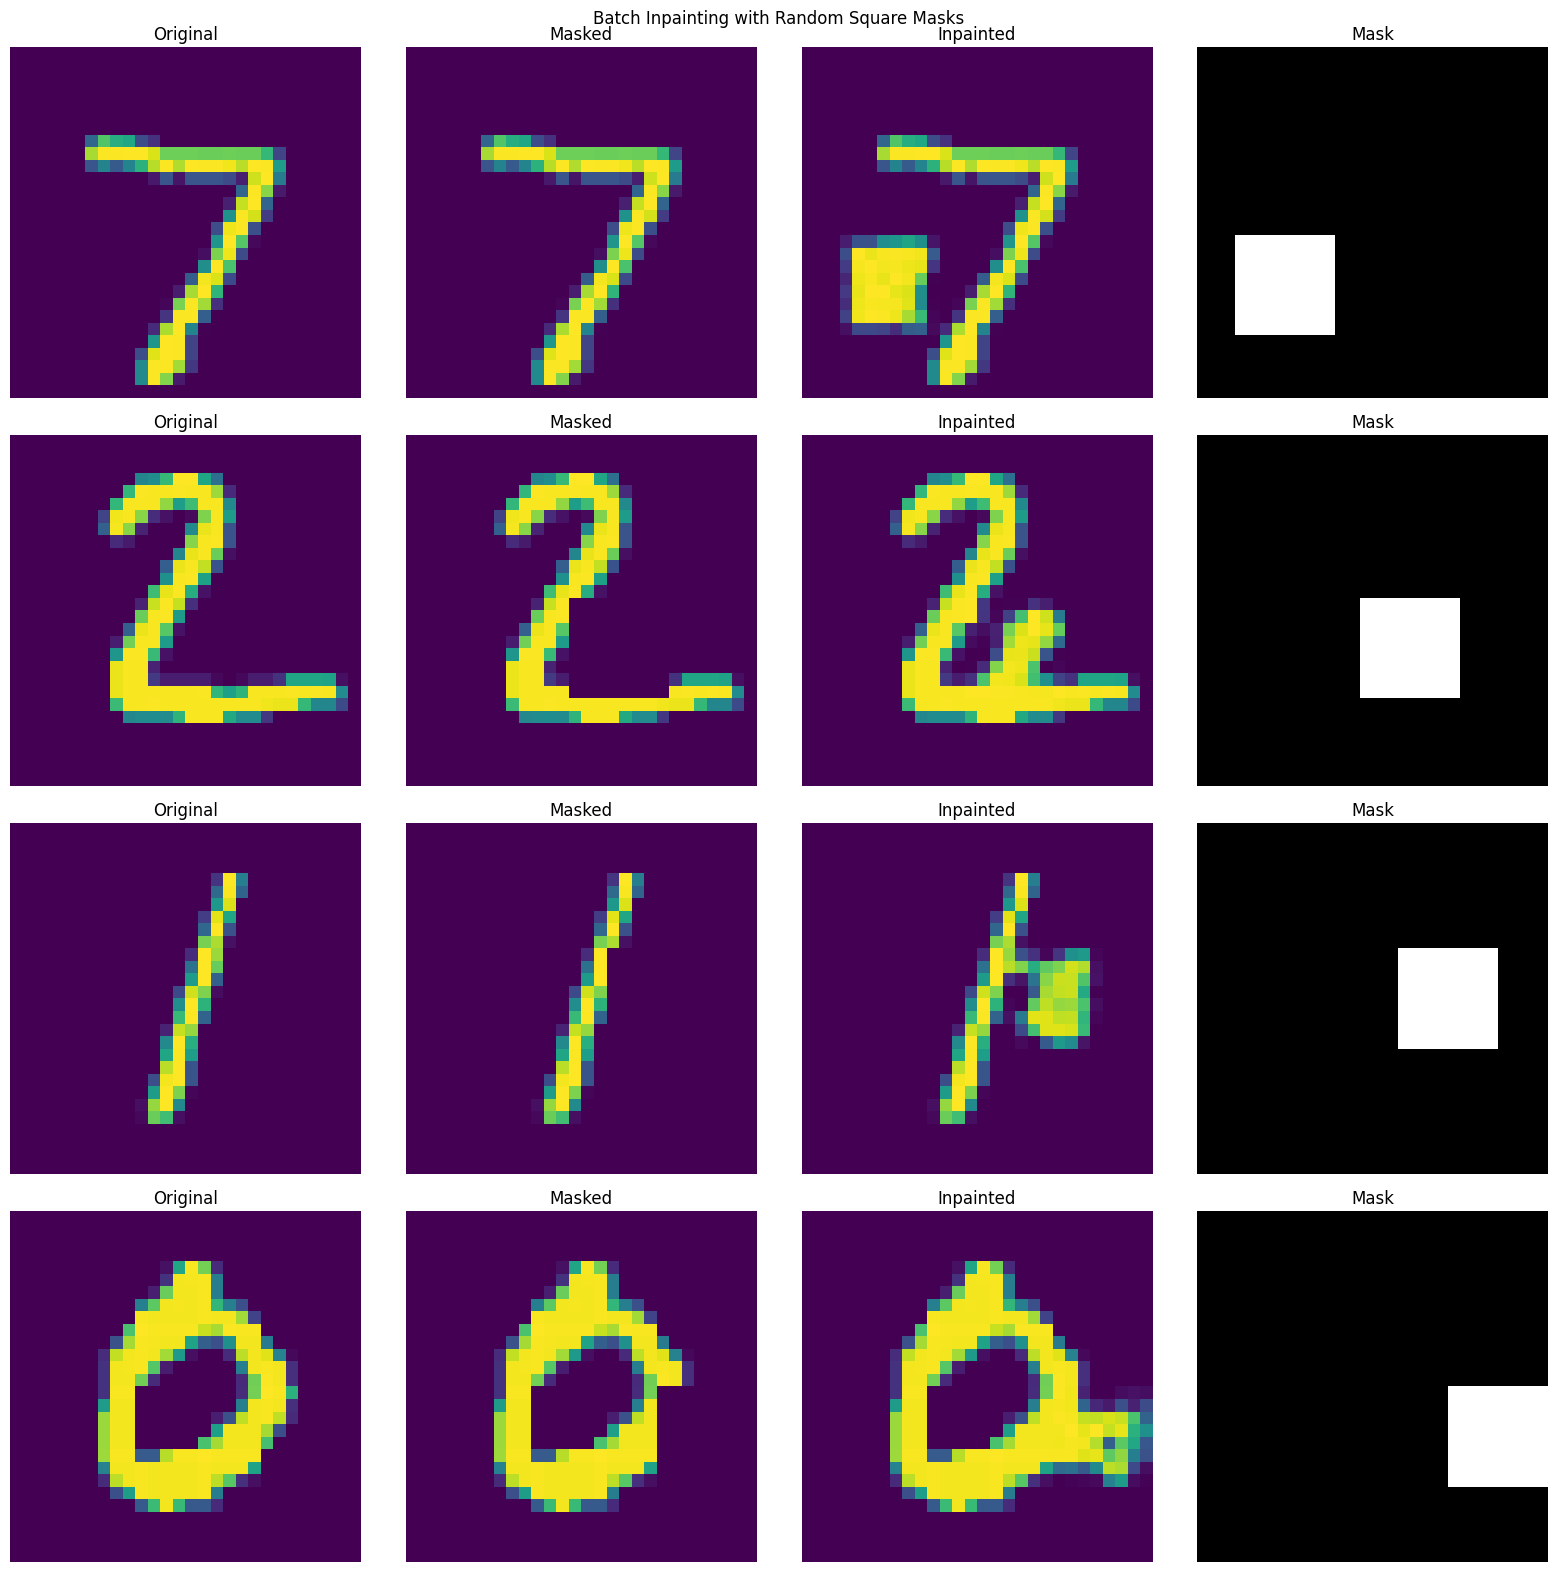

In [219]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")
